## Кейс №1 - Приложение знакомств

Вы работаете аналитиком в приложении для онлайн-знакомств. Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

Ваша задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать одну или несколько метрик, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

В [данных](https://disk.yandex.ru/d/txn7q-CE2zSaPg) находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему поиска анкет на всех пользователей.



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal

import requests
from urllib.parse import urlencode

sns.set(rc={'figure.figsize':(12,6)}, style="darkgrid")

Загрузим данные с помощью Яндекс апи.

In [ ]:
def get_ydisk_url(public_key: str) -> str:
  """Returns url from YandexDisc api"""
  base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
  final_url = base_url + urlencode(dict(public_key=public_key))
  response = requests.get(final_url)
  download_url = response.json()['href']
  return download_url

In [ ]:
dating_app_data = 'https://disk.yandex.ru/d/txn7q-CE2zSaPg'

In [ ]:
dating_df = pd.read_csv(get_ydisk_url(dating_app_data))

Проведем небольшое EDA и посмотрим на данные поближе.

In [ ]:
dating_df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [ ]:
dating_df.shape

(14514, 4)

In [ ]:
dating_df.nunique()

user_id_1    1000
user_id_2    1000
group           2
is_match        2
dtype: int64

In [ ]:
dating_df.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

In [ ]:
dating_df['group'].value_counts()

1    9722
0    4792
Name: group, dtype: int64

In [ ]:
dating_df['is_match'].value_counts()

0    9671
1    4843
Name: is_match, dtype: int64

Для нашего приложения важно чтобы количество людей у которых случился *'match'* увеличивалось. Поэтому мы будем сравнивать 2 группы в A/B тесте и сделаем вывод увеличилось ли количество *'match'*.

In [38]:
group_1 = dating_df[dating_df['group'] == 1]
group_0 = dating_df[dating_df['group'] == 0]

In [42]:
group_0['is_match'].mean()

0.19490818030050083

In [43]:
group_1['is_match'].mean()

0.40207776177741206

Создадим новую колонку для удобства визуализации и меньшей путаницы, где будут значения 'yes' если случился *match* и значения 'no' если нет.

In [ ]:
dating_df['is_match_y_no'] = dating_df['is_match'].apply(
    lambda x: 'yes' if x else 'no')

In [35]:
dating_df['is_match_y_no'].value_counts()

no     9671
yes    4843
Name: is_match_y_no, dtype: int64

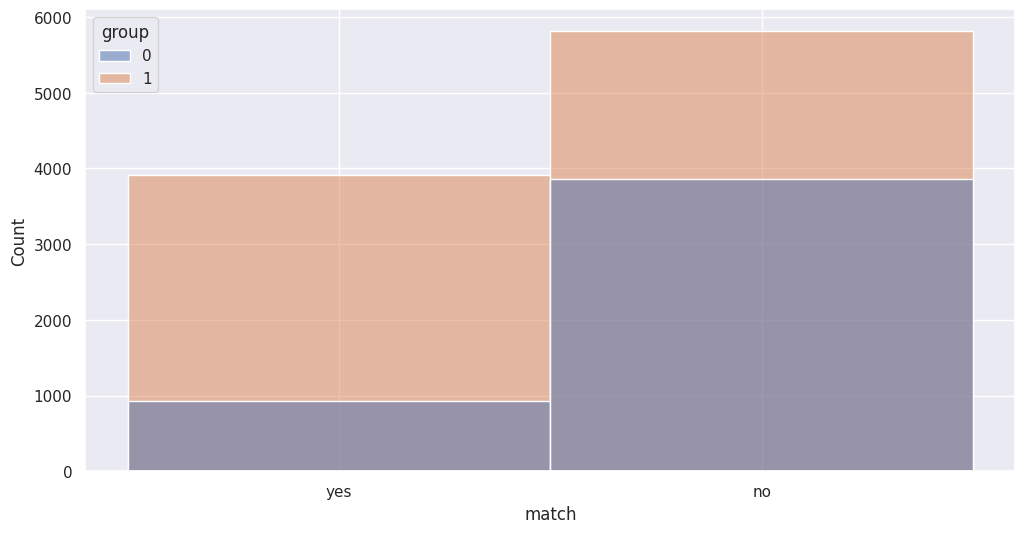

In [ ]:
sns.histplot(data=dating_df,
             x=dating_df['is_match_y_no'],
             hue='group')
plt.xlabel('match')
plt.show()

У нас есть две категориальные переменные, значит будем использовать хи-квадрат Пирсона.

H0 - среднее в групах не различается.

H1 - среднее в группах различаются.

In [ ]:
pd.crosstab(dating_df['is_match'], dating_df['group'])

group,0,1
is_match,,
0,3858,5813
1,934,3909


In [ ]:
stat, p, _, _ = chi2_contingency(pd.crosstab(dating_df['is_match'], dating_df['group']))

In [ ]:
stat, p

(618.6889141576197, 1.441829916366341e-136)

In [ ]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Судя по графику и проведенному статистическому тесту мы видим различия в контрольной и эксперементальной группах в сторону увеличения показателя *'match'*.

Поэтому мы можем сделать вывод: **включать новую систему поиска анкет на всех пользователей**.